In [2]:
from math import sqrt
from numpy import concatenate
import numpy as np
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import tree
from matplotlib import pyplot
import pandas as pd

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg



In [6]:
# load dataset
dataset = pd.read_excel('Smog.xlsx')
dataset.drop(columns='Unnamed: 0', axis=1, inplace=True)
dataset['Data'] = dataset['Data'].dt.round('H')
dataset.set_index('Data', inplace=True)
dataset.head()

,Dwutlenek_azotu,Tlenki_azotu,PM10,PM_2_5,Benzen,Tlenek_wegla,Kierunek_wiatru,Predkosc_wiatru,Temperatura,Wilgotnosc,Cisnienie
Data,,,,,,,,,,,
2020-01-01 01:00:00,19.7,35.0,34.3,17.9,0.2,0.7,278.0,2.471667,4.403333,62.058333,1002.798333
2020-01-01 02:00:00,22.8,43.5,32.2,15.0,0.2,0.7,279.0,2.200000,4.113333,61.336667,1002.940000
2020-01-01 03:00:00,31.8,68.4,35.7,16.3,0.2,0.8,270.0,1.906667,3.830000,62.410000,1003.261667
2020-01-01 04:00:00,26.4,52.6,34.0,15.0,0.2,0.7,278.0,1.998333,3.480000,63.541667,1003.481667
2020-01-01 05:00:00,24.5,50.4,26.1,11.6,0.2,0.7,277.0,2.248333,3.135000,64.786667,1003.888333


In [7]:
values = dataset.values
values[0]

array([1.97000000e+01, 3.50000000e+01, 3.43000000e+01, 1.79000000e+01,
       2.00000000e-01, 7.00000000e-01, 2.78000000e+02, 2.47166667e+00,
       4.40333333e+00, 6.20583333e+01, 1.00279833e+03])

In [8]:
# ensure all data is float
values = values.astype('float64')

In [9]:
# normalise features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

In [11]:
scaled[0]

array([0.0939759 , 0.03747047, 0.12759886, 0.07916851, 0.00947867,
       0.0047619 , 0.77222222, 0.30038453, 0.2760262 , 0.69524971,
       0.74684205])

In [18]:
# frame as supervised learning
n_mins = 5
n_features = 11
reframed = series_to_supervised(scaled, n_mins, 1)
# drop columns we don't want to predict
print(reframed.shape)

(8766, 66)


In [19]:
reframed

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var5(t-5),var6(t-5),var7(t-5),var8(t-5),var9(t-5),var10(t-5),...,var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t)
5,0.093976,0.037470,0.127599,0.079169,0.009479,0.004762,0.772222,0.300385,0.276026,0.695250,...,0.053683,0.093355,0.049093,0.004739,0.004762,0.766667,0.207645,0.234498,0.742012,0.768439
6,0.112651,0.046597,0.119038,0.066342,0.009479,0.004762,0.775000,0.263515,0.268428,0.685819,...,0.046489,0.079902,0.046882,0.009479,0.004762,0.763889,0.248360,0.233624,0.735870,0.774476
7,0.166867,0.073330,0.133306,0.072092,0.009479,0.005442,0.750000,0.223705,0.261004,0.699845,...,0.055078,0.063596,0.042017,0.004739,0.004762,0.752778,0.273920,0.248341,0.670377,0.783234
8,0.134337,0.056367,0.126376,0.066342,0.009479,0.004762,0.772222,0.236146,0.251834,0.714634,...,0.046274,0.070526,0.044670,0.009479,0.004082,0.744444,0.319159,0.251397,0.653323,0.784226
9,0.122892,0.054005,0.094170,0.051305,0.009479,0.004762,0.769444,0.270075,0.242795,0.730904,...,0.042946,0.106808,0.046882,0.004739,0.004762,0.769444,0.324813,0.253493,0.660401,0.785615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8766,0.263855,0.183917,0.187525,0.090226,0.080569,0.006803,0.497130,0.133931,0.248113,0.777552,...,0.174039,0.200978,0.127820,0.113744,0.007483,0.443103,0.148385,0.210257,0.843010,0.476188
8767,0.282530,0.181984,0.200978,0.095975,0.075829,0.006803,0.447500,0.139632,0.237790,0.791294,...,0.115954,0.202201,0.133127,0.127962,0.006122,0.436973,0.158856,0.208926,0.844675,0.476358
8768,0.311446,0.201739,0.198940,0.108359,0.118483,0.007483,0.440463,0.143483,0.227990,0.805089,...,0.089757,0.182634,0.120743,0.085308,0.005442,0.480651,0.156230,0.207046,0.847537,0.476484
8769,0.294578,0.178441,0.190379,0.114551,0.104265,0.007483,0.482963,0.143785,0.222055,0.816510,...,0.114022,0.201794,0.137992,0.085308,0.006122,0.394828,0.155851,0.205160,0.849117,0.475131


In [20]:
# split into train and test sets
values = reframed.values
n_train_mins = 4 * 24 * 60
train = values[:n_train_mins, :]
test = values[n_train_mins:, :]

In [31]:
# split into input and outputs
n_obs = n_mins * n_features
train_X, train_y = train[:, :n_obs], train[:, 3]
test_X,  test_y =test[:, :n_obs], test[:, 3]
print(train_y, test_y)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

[0.07916851 0.06634233 0.07209199 ... 0.07164971 0.07961079 0.05749668] [0.03936311 0.03272888 0.02521008 ... 0.10835913 0.11455108 0.12030075]
(5760, 55) (5760,) (3006, 55) (3006,)


In [32]:
# design dt model
clf = tree.DecisionTreeRegressor()

# fit model
clf.fit(train_X,train_y)

# make a prediction
predict_y = clf.predict(test_X)

In [33]:
print(test_y)
print(predict_y)

[0.03936311 0.03272888 0.02521008 ... 0.10835913 0.11455108 0.12030075]
[0.03936311 0.03272888 0.02521008 ... 0.10835913 0.11455108 0.12030075]


In [34]:
yhat = predict_y.reshape(predict_y.shape[0], 1)
yhat

array([[0.03936311],
       [0.03272888],
       [0.02521008],
       ...,
       [0.10835913],
       [0.11455108],
       [0.12030075]])

In [35]:
test_X = test_X.reshape((test_X.shape[0],n_mins*n_features))
print(yhat.shape,test_X.shape)

(3006, 1) (3006, 55)


In [46]:
# invert scaling for forecast
inv_yhat = concatenate((test_X[:, -11:-1], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-8]
inv_yhat

array([ 5.1,  5.4,  6.7, ..., 30.1, 27.3, 31.2])

In [47]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, -11:-1], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-8]
inv_y

array([ 5.1,  5.4,  6.7, ..., 30.1, 27.3, 31.2])

In [50]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 0.000


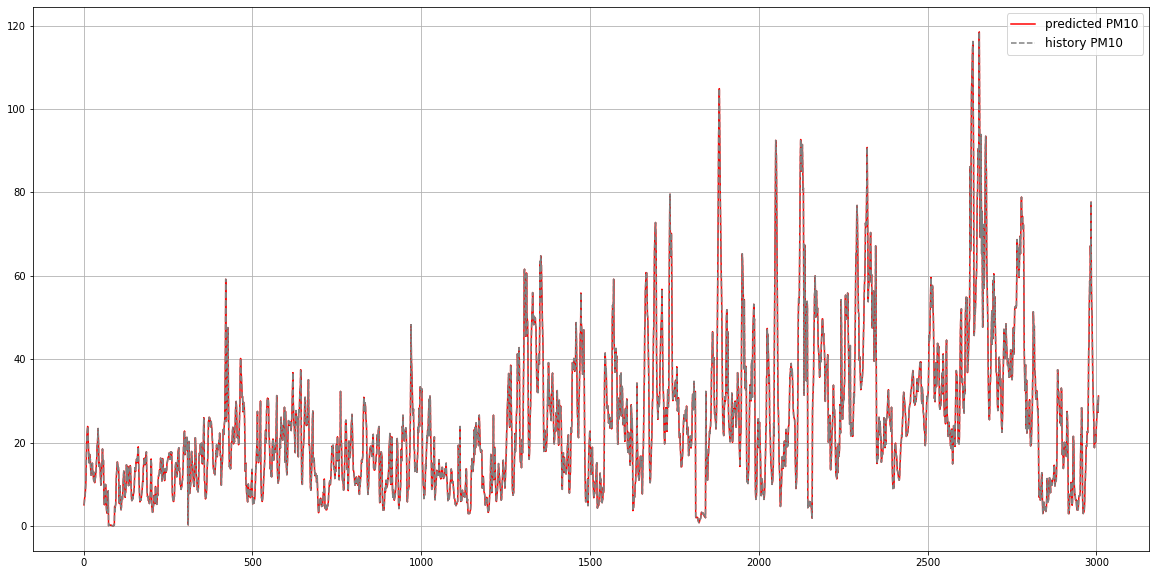

In [52]:
# plot 
pyplot.figure(figsize=(20, 10))
pyplot.plot([x for x in range(1, inv_yhat.shape[0]+1)], inv_yhat, linestyle='-', color='red', label='predicted PM10')
pyplot.plot([x for x in range(1, inv_y.shape[0]+1)], inv_y, linestyle='--', color='grey', label='history PM10')
pyplot.legend(loc=1, prop={'size': 12})
pyplot.grid()
pyplot.show()